# LSTM

LSTMs are RNNs designed to handle sequential data and are easily adaptable for sentiment analysis. They're designed to maintain memory cells and gates to capture long-range patterns that traditional RNNs fail to do so per the vanishing gradient problem.

In [1]:
from collections import Counter

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe, build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

df = pd.read_csv('sentiment140_cleaned.csv')
texts = df['clean_text'].astype(str)
labels = df['sentiment']

X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=734)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=734)

For our embeddings, we'll load in pre-trained embeddings (GloVe). Let's also use the nltk TweetTokenizer which is already pre-trained on tweets.

We will also look to do compute heavy tasks (training) on GPU.

In [2]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Pre-trained embeddings
dim = 300
glove = GloVe(name='6B', dim=dim)

# Tokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True).tokenize
tokenized_train = [tokenizer(text) for text in X_train]
tokenized_val = [tokenizer(text) for text in X_val]
tokenized_test = [tokenizer(text) for text in X_test]

def yield_tokens_with_freq(tokenized_texts):
    token_counter = Counter()
    for tokens in tokenized_texts:
        token_counter.update(tokens)
        yield tokens
    return token_counter

# Build vocab
token_counter = Counter()
vocab = build_vocab_from_iterator(
    yield_tokens_with_freq(tokenized_train),
    specials=["<unk>", "<pad>"],
    min_freq=1
)
vocab.set_default_index(vocab["<unk>"])
token_freq = token_counter

We can also look to create our embedding matrix (embedding lookup for tokens). Note for tokens that aren't in our vocabulary, we'll just use a mean of all the embeddings.

In [3]:
mean_embedding = torch.mean(torch.stack([glove[token] for token in glove.stoi]), dim=0)
embedding_matrix = torch.zeros(len(vocab), dim)
for i, token in enumerate(vocab.get_itos()):
    embedding_matrix[i] = glove[token] if token in glove.stoi else mean_embedding

embedding_matrix[0].shape # using glove 300

torch.Size([300])

Now we have our embeddings/vocab setup so we can transform our text into tensors and define datasets/dataloaders to load our data into the model for training.

In [4]:
def text_to_indices(texts, vocab, tokenizer, max_len=150):
    indices = []
    for text in texts:
        tokens = tokenizer(text)[:max_len]
        idx = [vocab[token] for token in tokens]
        idx += [vocab["<pad>"]] * (max_len - len(idx))
        indices.append(idx)
    return torch.tensor(indices, dtype=torch.long)

# Prepare datasets
max_len = 150
X_train_idx = text_to_indices(X_train, vocab, tokenizer, max_len)
X_val_idx = text_to_indices(X_val, vocab, tokenizer, max_len)
X_test_idx = text_to_indices(X_test, vocab, tokenizer, max_len)

train_dataset = TensorDataset(X_train_idx, torch.tensor(y_train.values, dtype=torch.long))
val_dataset = TensorDataset(X_val_idx, torch.tensor(y_val.values, dtype=torch.long))
test_dataset = TensorDataset(X_test_idx, torch.tensor(y_test.values, dtype=torch.long))

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Now we're ready to define the LSTM classifier!

First, the requires_grad = True, here we initially alowing token embeddings to be updated during back-propagation but freezing them if they are too frequent. This is to help reduce overfitting and the impact of high-frequency tokens like 'I', 'the', 'and', etc.

Second, we are including attention and dropout layers in our LSTM.

Finally, notice in self.fc we are multiplying hidden_dim*2, this is to make our LSTM bi-directional (forward and backward) to hopefully pick up more information from the tweet. 

In [5]:
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix, pad_idx, num_layers=1, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = True
        # Selectively freeze high-frequency tokens
        freq_threshold = 5
        for i, token in enumerate(vocab.get_itos()):
            if token_freq.get(token, 0) > freq_threshold:
                self.embedding.weight.data[i].requires_grad = False

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        context = self.dropout(context)
        return self.fc(context)

Now let's set up our training loop.

An Adam optimizer is pretty standard, it combines an adaptive learning rate with momentum to overcome local minima. Cross-entropy loss is also a standard for classification, it applies an especially large penalty for confidently incorrect predictions.

We also include some early stopping parameters to exit our training epochs if learning stalls.

In [6]:
model = LSTMSentiment(
    vocab_size=len(vocab),
    embedding_dim=dim,
    hidden_dim=64,
    output_dim=2,
    embedding_matrix=embedding_matrix,
    pad_idx=vocab["<pad>"],
    num_layers=2,
    dropout=0.5
).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
class_weights = torch.tensor([1.3, 1.0], dtype=torch.float).to(device)  # Adjusted for negative class
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

# Early stopping parameters
patience = 3
min_delta = 0.001
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

Training loop:

In [7]:
epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_acc = train_correct / train_total
    train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            val_loss += criterion(outputs, y_batch).item()
            preds = outputs.argmax(1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break

Epoch 1/15, Train Loss: 0.6877, Train Acc: 0.4927, Val Loss: 0.6831, Val Acc: 0.5113
Epoch 2/15, Train Loss: 0.6773, Train Acc: 0.5261, Val Loss: 0.6428, Val Acc: 0.6353
Epoch 3/15, Train Loss: 0.5849, Train Acc: 0.6861, Val Loss: 0.5280, Val Acc: 0.7433
Epoch 4/15, Train Loss: 0.4944, Train Acc: 0.7529, Val Loss: 0.4992, Val Acc: 0.7593
Epoch 5/15, Train Loss: 0.4477, Train Acc: 0.7841, Val Loss: 0.5062, Val Acc: 0.7693
Epoch 6/15, Train Loss: 0.4068, Train Acc: 0.8074, Val Loss: 0.5135, Val Acc: 0.7633
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch 7/15, Train Loss: 0.3607, Train Acc: 0.8436, Val Loss: 0.5231, Val Acc: 0.7707
Early stopping triggered after epoch 7


We're getting marginally better validation accuracy, around 77%. We can also see some systematic overfitting where training accuracy outstrips validation accuracy, especially in the later epochs. Now let's evaluate the model on the test set.

Test Accuracy: 0.7547


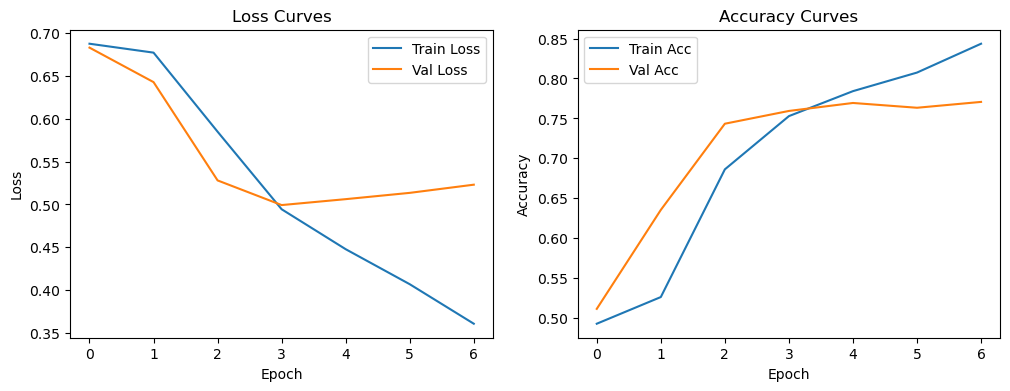

In [8]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)

model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(1)
        test_correct += (preds == y_batch).sum().item()
        test_total += y_batch.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print(f"Test Accuracy: {test_correct/test_total:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

We can see our test accuracy outperforms our baseline 74% to 76%. We can also see here overfitting ocurring after epoch 3, where validation loss and accuracy plateau.

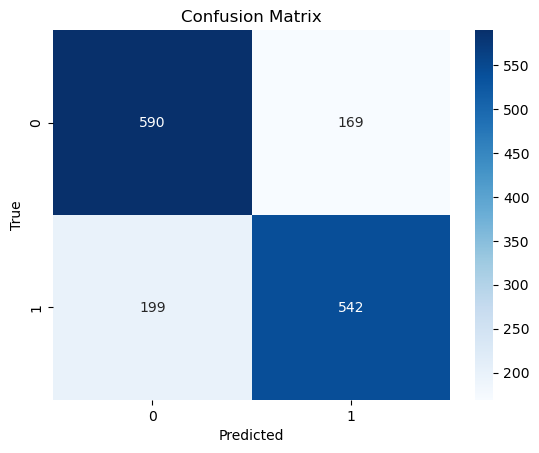

In [9]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Our confusion matrix isn't particularly over-predicting one class over another. There's still room for improvement here, we'd want to reach a benchmark of around 80%. However, LSTMs aren't the perfect choice for these analyses. We'll look to top this with BERT.